In [4]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import numpy as np

warnings.filterwarnings('ignore')

In [5]:
# Check and test

file_path = '/content/Alphabet_data.csv'


try:
    df_test= pd.read_csv(file_path, sep=';', header=0)

    # Clean up empty columns
    df_test = df_test.dropna(axis=1, how='all')

    print("Data loaded successfully!")
    print("Columns found:", df_test.columns.tolist())
    display(df_test.head())

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")

Data loaded successfully!
Columns found: ['Company', 'Date', 'Quarter', 'Year', 'Revenue']


,Company,Date,Quarter,Year,Revenue
0,Alphabet,2025-09-30,Q3,2025,102346
1,Alphabet,2025-06-30,Q2,2025,96428
2,Alphabet,2025-03-31,Q1,2025,90234
3,Alphabet,2024-12-31,Q4,2024,96469
4,Alphabet,2024-09-30,Q3,2024,88268


In [6]:
# 1. CONFIG

CONFIG = {
    "file_path": "/content/Alphabet_data.csv",
    "entity_name": "Alphabet",
    "regressor_entity": "Amazon",
    "years_to_predict": 3,
    "separator": ";",
    "header_row": 0,       # Changed to 0 based on your df_test code
    "columns": {
        "date": "Date",    # Ensure this matches your CSV column name (e.g. 'Date' or 'Year')
        "target": "Revenue",
        "entity": "Company"
    }
}

# Scenarios (Stress Test Strategy)
SCENARIOS = {
    "Bear Case":  0.05,  # Crisis / Recession (5%)
    "Base Case":  0.10,  # Consensus (10%)
    "Bull Case":  0.15   # AI Supercycle (15%)
}

In [7]:
# 2. DATA LOADING & VALIDATION MODULE

def load_and_validate_data(config):
    """Loads data from disk, cleans it, and performs safety checks."""
    print(f"---  LOADING DATA FROM: {config['file_path']} ---")

    if not os.path.exists(config['file_path']):
        print(f" Critical Error: File not found at {config['file_path']}")
        return None

    try:
        # Load from file
        df = pd.read_csv(
            config['file_path'],
            sep=config.get('separator', ';'),
            header=config.get('header_row', 0),
            engine='python'
        )

        # Cleanup
        df = df.dropna(how='all', axis=1).dropna(how='all', axis=0)
        df.columns = df.columns.str.strip()

        # Validation: Check for missing columns
        required_cols = list(config['columns'].values())
        missing = [c for c in required_cols if c not in df.columns]
        if missing:
            raise ValueError(f" Missing expected columns: {missing}")

        # Validate Date Column
        df[config['columns']['date']] = pd.to_datetime(df[config['columns']['date']])

        # Pivot Data (Wide Format)
        df_pivot = df.pivot(
            index=config['columns']['date'],
            columns=config['columns']['entity'],
            values=config['columns']['target']
        ).reset_index()

        # Validation: Check overlap
        before_len = len(df_pivot)
        target_col = config['entity_name']
        reg_col = config['regressor_entity']

        if target_col not in df_pivot.columns or reg_col not in df_pivot.columns:
            raise ValueError(f" Entities {target_col} or {reg_col} not found in data.")

        # Drop NaNs and Warn
        df_pivot = df_pivot.dropna(subset=[target_col, reg_col])
        if len(df_pivot) < before_len:
            print(f"Warning: Dropped {before_len - len(df_pivot)} rows due to missing data overlap.")

        if len(df_pivot) < 8:
            print(" Warning: Dataset is short (< 8 quarters). Seasonality accuracy may be lower.")

        # Calculate Correlation for User Verification
        corr = df_pivot[target_col].corr(df_pivot[reg_col])
        print(f"Data Loaded. Quarterly Correlation: {corr:.4f}")

        return df_pivot

    except Exception as e:
        print(f"Data Load Error: {e}")
        return None

In [8]:
# 3. FORECASTING ENGINE

def run_scenario_forecast(df, config, scenarios):
    """Runs Prophet model for multiple scenarios."""
    print(f"--- STARTING FORECAST: {config['entity_name']} ---")

    # Prepare Prophet DataFrame
    df_prophet = pd.DataFrame()
    df_prophet['ds'] = df[config['columns']['date']]
    df_prophet['y'] = df[config['entity_name']].astype(float)
    df_prophet['competitor_signal'] = df[config['regressor_entity']].astype(float)

    # TRAIN MODEL
    # Improvement: Added 'quarterly' seasonality explicitly for financial accuracy
    model = Prophet(seasonality_mode='multiplicative', yearly_seasonality=True)
    model.add_seasonality(name='quarterly', period=365.25/4, fourier_order=5)
    model.add_regressor('competitor_signal')
    model.fit(df_prophet)

    results_list = []

    # Calculate Forecast Horizon
    quarters_to_predict = (config['years_to_predict'] * 4) + 1

    for name, rate in scenarios.items():
        future = model.make_future_dataframe(periods=quarters_to_predict, freq='Q')

        # Regressor Projection (Seasonal Recursion)
        future_comp_vals = list(df_prophet['competitor_signal'].values)
        current_len = len(future_comp_vals)
        total_len = len(future)

        for i in range(current_len, total_len):
            # Safe logic: Look back 4 quarters to preserve seasonality
            if i >= 4:
                val_last_year = future_comp_vals[i - 4]
                future_comp_vals.append(val_last_year * (1 + rate))
            else:
                future_comp_vals.append(future_comp_vals[-1] * (1 + rate))

        future['competitor_signal'] = future_comp_vals

        # Predict
        forecast = model.predict(future)

        # Store Results
        res = forecast[['ds', 'yhat']].copy()
        res['Scenario'] = name
        results_list.append(res)

    return pd.concat(results_list), df_prophet

In [9]:
# 4. VISUALIZATION & REPORTING

def visualize_results(results_df, history_df, config):
    """Plots the scenarios and prints the summary table."""
    sns.set_theme(style="white")
    fig, ax = plt.subplots(figsize=(12, 7))

    # Plot History
    ax.plot(history_df['ds'], history_df['y'], 'ko', markersize=5, label='Historical Actuals', zorder=5)

    # Plot Scenarios
    colors = {"Bear Case": "#ef5350", "Base Case": "#0d47a1", "Bull Case": "#66bb6a"}

    # Filter only future data for plotting clarity
    last_hist_date = history_df['ds'].max()
    future_plot = results_df[results_df['ds'] > last_hist_date]

    for name in results_df['Scenario'].unique():
        subset = future_plot[future_plot['Scenario'] == name]
        style = '-' if name == "Base Case" else '--'
        width = 3 if name == "Base Case" else 2
        ax.plot(subset['ds'], subset['yhat'], color=colors.get(name, 'gray'),
                linewidth=width, linestyle=style, label=name)

    # Dynamic Title
    start_year = future_plot['ds'].dt.year.min()
    end_year = future_plot['ds'].dt.year.max()

    ax.set_title(f"{config['entity_name']} Revenue Forecast ({start_year}-{end_year})\nBased on Quarterly Regressors",
                 fontsize=16, fontweight='bold', pad=20, color='#222222')

    sns.despine(left=True)
    ax.grid(axis='y', linestyle=':', alpha=0.3)
    ax.legend(frameon=False, loc='upper left')
    ax.set_xlabel("")
    ax.set_ylabel("Revenue")
    plt.tight_layout()
    plt.show()

    # Generate Summary Table
    print("\n--- ANNUAL REVENUE FORECAST (Billions $) ---")
    results_df['Year'] = results_df['ds'].dt.year

    # Filter only future years for the table
    future_years_only = results_df[results_df['ds'] > last_hist_date]

    annual_summary = future_years_only.groupby(['Year', 'Scenario'])['yhat'].sum().unstack()

    # Convert to Billions (Assuming input is Millions)
    annual_summary = annual_summary / 1000
    display(annual_summary.round(1))

---  LOADING DATA FROM: /content/Alphabet_data.csv ---
Data Loaded. Quarterly Correlation: 0.9925
--- STARTING FORECAST: Alphabet ---


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


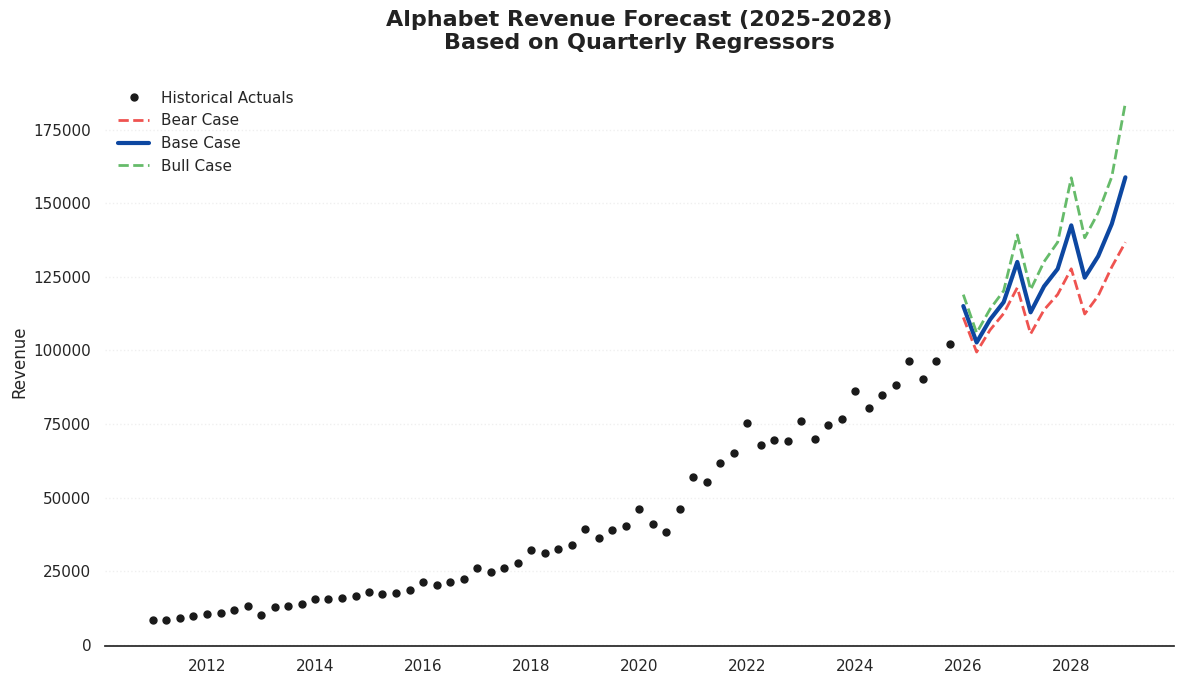


--- ANNUAL REVENUE FORECAST (Billions $) ---


Scenario,Base Case,Bear Case,Bull Case
Year,,,
2025,115.1,111.2,118.9
2026,459.7,440.3,479.5
2027,504.9,466.1,546.1
2028,558.5,496.0,628.1


In [10]:
# 5. MAIN EXECUTION

if __name__ == "__main__":
    clean_data = load_and_validate_data(CONFIG)

    if clean_data is not None:
        forecast_results, history_data = run_scenario_forecast(clean_data, CONFIG, SCENARIOS)
        visualize_results(forecast_results, history_data, CONFIG)